# Caso Yaku

# Circulação Ciclônica em frente ao Peru e Equador (13 de março de 2023)

Formed           :7 de March de 2023

Extratropical    :13 de março de 2023

Dissipated       :20 de March de 2023

Areas affected   : Peru

***Note: we run the plotting scripts as Python modules, but they can also be run in the command-line if you wish.***

### Bibliotecas necessárias

In [1]:
import os
from datetime import datetime, timedelta  # Para manipular datas e calcular intervalos de tempo.

import xarray as xr
import numpy as np  # Para cálculos com matrizes.
import matplotlib.pyplot as plt  # Para gráficos e mapas.

import cartopy.crs as ccrs  # Projeções de mapas.
import cartopy.feature as cfeature  # Elementos geográficos.


from scipy.interpolate import RegularGridInterpolator  # Para interpolar dados entre grades diferentes.

import csv # Para ler e escrever arquivos CSV (onde os resultados são salvos)

from scipy.ndimage import gaussian_filter  # Para suavizar dados (usado em omega).

import metpy.calc as mpcalc
from metpy.units import units

#Local scripts
import data_io, color_setup, aux

# import requests,fsspec

### CONFIGURAÇÕES

### Datas dos 6 dias consecutivos a serem plotados.

In [2]:
datas = [
    "20230308",
    "20230309",
    "20230310",
    "20230311",
    "20230312",
    "20230313"
]


### Datas das rodadas (início das simulações) e previsões (futuro previsto).

In [3]:
rodadas = ["2023030700", "2023030800", "2023030900", "2023031000", "2023031100"]
previsoes = ["2023030800", "2023030900", "2023031000", "2023031100", "2023031200"]

### Detecta quais combinações de rodada e previsão têm dados para gerar gráficos

In [4]:
primeira_coluna_com_dado = [None] * len(rodadas)
ultima_linha_com_dado = [None] * len(previsoes)
for i, rodada in enumerate(rodadas):
    for j, previsao in enumerate(previsoes):
        if rodada == previsao:
            continue
        if data_io.check_monan(rodada, previsao):
            if primeira_coluna_com_dado[i] is None:
                primeira_coluna_com_dado[i] = j
            ultima_linha_com_dado[j] = i


### Limites geográficos do mapa 

In [5]:
extent = [-90, -70, -20, 0]
# Limites geográficos do mapa: longitude (oeste a leste) e latitude (sul a norte).
lon_min, lon_max = -110, -70
lat_min, lat_max = -30, 10

### Intervalos de tempo de previsão (lead times) em horas. 

In [6]:
# Ex: 0h (análise), 24h, 48h, ..., 120h.
forecast_steps_h = list(range(0, 121, 24))

### Preparação das escalas de cores

In [7]:
cmap_daily, norm_daily= color_setup.color_setup(type='daily')
cmap_sum, norm_sum= color_setup.color_setup(type='sum')

# Intervalos de precipitação para os dias individuais.
boundaries = [0, 10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
# Intervalos para o acumulado dos 6 dias.
boundaries2 = [0, 50, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]


# 1. Precipitação MERGE 

## Leitura dos arquivos MERGE, recorte e armazenamento dos dados

In [8]:
prec_list = []
lats_merge = None
lons_merge = None

for data in datas:
    ds = data_io.load_merge(data)

    # Check if latitudes are ascending or descending
    lat_vals = ds['latitude'].values
    
    # Determine the correct slice order based on data organization
    if lat_vals[0] > lat_vals[-1]:
        # Descending (90 to -90)
        lat_slice = slice(extent[3], extent[2])  # slice(5, -20)
    else:
        # Ascending (-90 to 90)
        lat_slice = slice(extent[2], extent[3])  # slice(-20, 5)
    
    # Extract the data and coordinates as numpy array 
    ds_subset = ds.sel(
        latitude=lat_slice,
        longitude=slice(extent[0]+360, extent[1]+360)  # slice(270, 290)
    )
    
    
    prec = ds_subset['rdp'].values  # Get the data values
    lats = ds_subset['latitude'].values  # Get latitude coordinates
    lons = ds_subset['longitude'].values  # Get longitude coordinates
        
    ds.close()

    prec_list.append(prec)
    if lats_merge is None:
        lats_merge = lats
        lons_merge = lons

Using existing cached index: /home/aluno01/.cfgrib_cache/MERGE_CPTEC_20230308.grib2.idx


/home/aluno01/.conda/envs/cursowmo_env/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.42.0 or higher is recommended. You are running version 2.32.1
  warnings.warn(


KeyError: 'rdp'

### VERIFICAÇÃO E ACUMULADO

In [9]:
if len(prec_list) == 0:
    raise RuntimeError("Nenhum arquivo MERGE encontrado!")

# Calcula o acumulado somando as precipitações diárias.
prec_all = np.stack(prec_list)
prec_sum = np.sum(prec_all, axis=0)


## PREPARA FIGURA DE PRECIPITAÇÃO MERGE

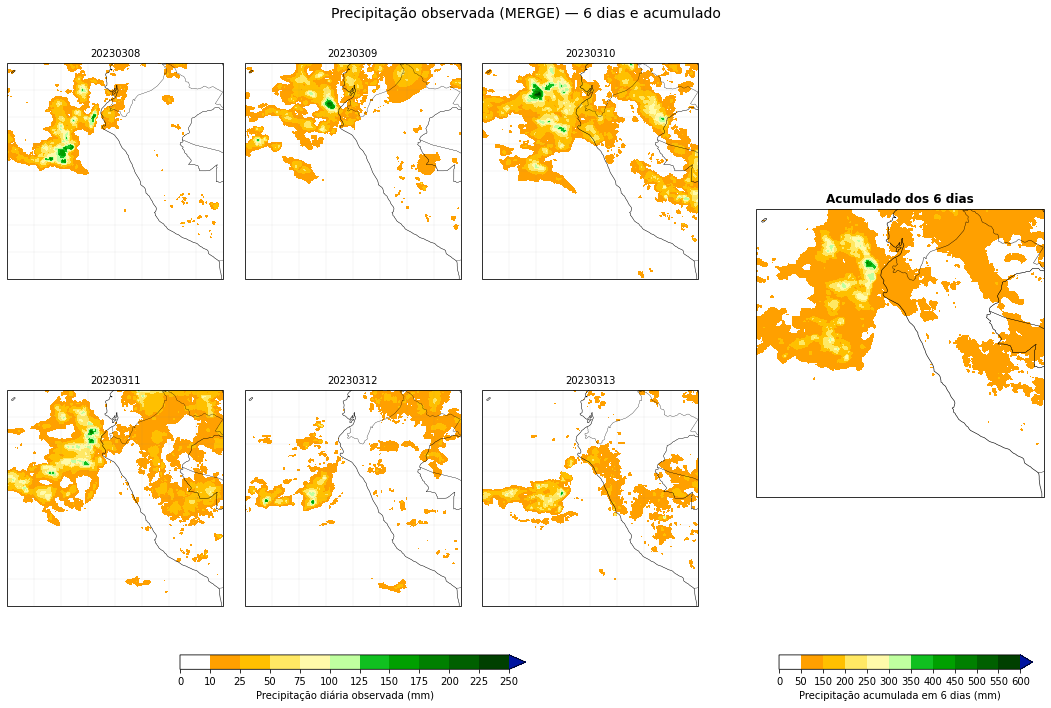

✅ Figura salva como precip_merge.png


In [10]:
# Cria figura com ajustes de espaçamento.
fig = plt.figure(figsize=(16, 10))
plt.subplots_adjust(left=0.05, right=0.65, top=0.95, bottom=0.10, hspace=0.15, wspace=0.1)

# Cria painéis 2x3 para dias individuais e um maior para o acumulado.
axes = [fig.add_subplot(2, 3, i+1, projection=ccrs.PlateCarree()) for i in range(6)]
ax_total = fig.add_axes([0.70, 0.15, 0.25, 0.7], projection=ccrs.PlateCarree())

# -------------------------------
# PLOTAGEM DOS DIAS INDIVIDUAIS
# -------------------------------
for i, (ax, data) in enumerate(zip(axes, datas)):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.STATES, linewidth=0.2)

    # Plota precipitação diária.
    cf = ax.contourf(lons_merge, lats_merge, prec_list[i],
                     levels=boundaries, cmap=cmap_daily, norm=norm_daily,
                     extend='max', transform=ccrs.PlateCarree())

    ax.set_title(f"{data}", fontsize=10)
    ax.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.4)

# -------------------------------
# PLOTAGEM DO ACUMULADO
# -------------------------------
ax_total.set_extent(extent, crs=ccrs.PlateCarree())
ax_total.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax_total.add_feature(cfeature.BORDERS, linewidth=0.4)
ax_total.add_feature(cfeature.STATES, linewidth=0.3)

# Plota acumulado dos 6 dias.
cf_total = ax_total.contourf(lons_merge, lats_merge, prec_sum,
                             levels=boundaries2, cmap=cmap_sum, norm=norm_sum,
                             extend='max', transform=ccrs.PlateCarree())

ax_total.set_title("Acumulado dos 6 dias", fontsize=12, fontweight='bold')

# -------------------------------
# BARRAS DE CORES E SALVAMENTO
# -------------------------------
# Barra de cores para os dias individuais.
cbar_ax1 = fig.add_axes([0.20, 0.06, 0.3, 0.02])
fig.colorbar(cf, cax=cbar_ax1, orientation='horizontal',
             ticks=boundaries, label='Precipitação diária observada (mm)')

# Barra de cores para o acumulado.
cbar_ax2 = fig.add_axes([0.72, 0.06, 0.22, 0.02])
fig.colorbar(cf_total, cax=cbar_ax2, orientation='horizontal',
             ticks=boundaries2, label='Precipitação acumulada em 6 dias (mm)')

plt.suptitle("Precipitação observada (MERGE) — 6 dias e acumulado", fontsize=14, y=0.98)
plt.savefig("precip_merge.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✅ Figura salva como precip_merge.png")

# 2 PRECIPITAÇÃO PREVISTA (VALOR OU VIÉS)

## Define se plota Precipitação ou viés

In [11]:
# Se True, plota viés
plot_vies = False

### Configuração de cores e escalas

In [12]:
cmap2, data_min, data_max, rain_levels, levels2 = color_setup.cores_precip()

## Geração da figura

Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030812.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030712.00.00.x1.5898242L55.nc
Using existing cached index: /home/madeleine.gacita/.cfgrib_cache/MERGE_CPTEC_20230313.grib2.idx
Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030912.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030812.00.00.x1.5898242L55.nc
Using existing cached index: /home/madeleine.gacita/.cfgrib_cache/MERGE_CPTEC_20230313.grib2.idx
Plotando para este painel
Opening  /pe

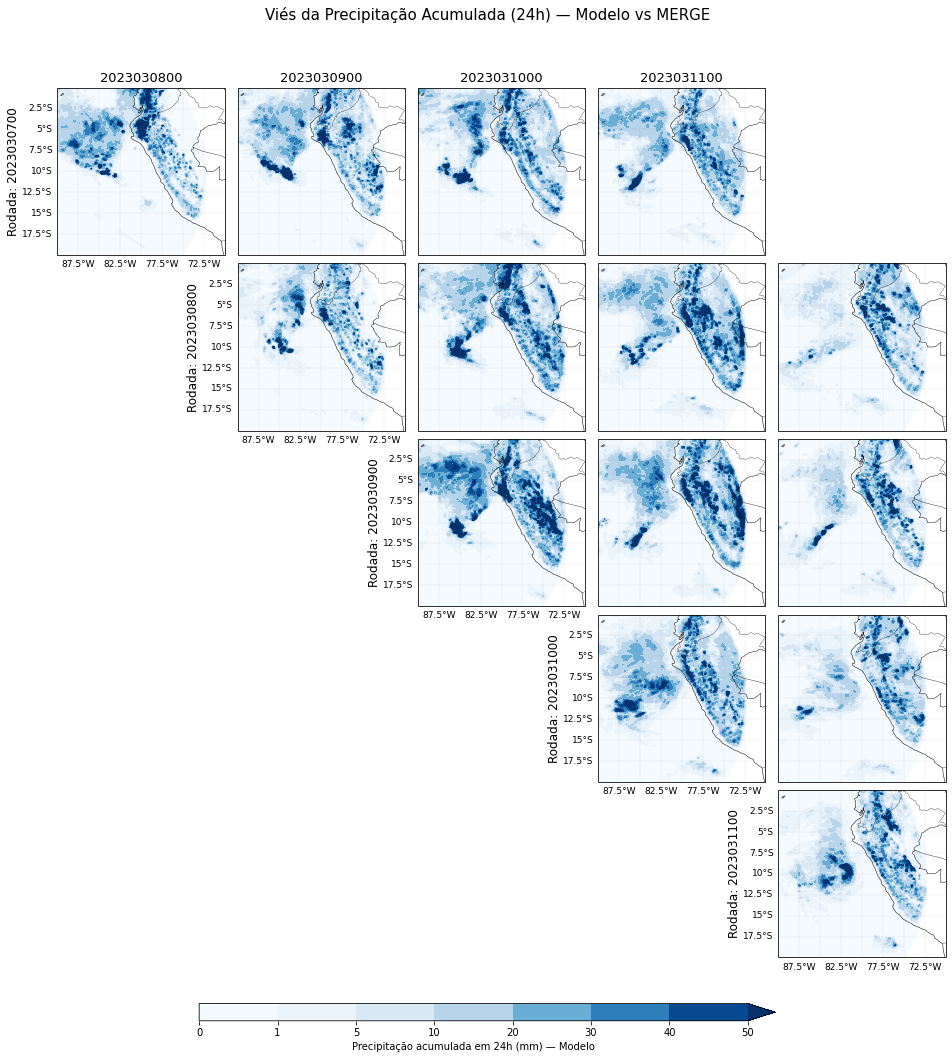

✅ Figura salva: /pesq/dados/monan/users/madeleine.gacita/curso_wmo/previsao_precip_vies_merge.png


In [13]:
fig, axs = plt.subplots(len(rodadas), len(previsoes),
                        figsize=(16, 16),
                        subplot_kw=dict(projection=ccrs.PlateCarree()),
                        gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
axs = np.atleast_2d(axs)  # Garante que axs seja uma matriz 2D.

# Variável para guardar o último contorno válido (para a colorbar).
last_valid_cf = None
for i, rodada in enumerate(rodadas):
    for j, previsao in enumerate(previsoes):
        ax = axs[i, j]
        ax.set_extent([extent[0], extent[1], extent[2], extent[3]], crs=ccrs.PlateCarree())

        # Adiciona rótulo da rodada na primeira coluna visível.
        if j == primeira_coluna_com_dado[i]:
            ax.text(-0.3, 0.5, f"Rodada: {rodada}", fontsize=12, va='center',
                    rotation=90, transform=ax.transAxes)

        try:
            if rodada == previsao:
                ax.set_visible(False)
                continue

            # Calcula datas para os arquivos MERGE (observações fecham às 12Z).
            merge_date_str = previsao[:8]
            merge_date = datetime.strptime(merge_date_str, '%Y%m%d')
            target_current = merge_date.strftime('%Y%m%d') + '12'
            prev_date = (merge_date - timedelta(days=1))
            target_prev = prev_date.strftime('%Y%m%d') + '12'

            # Verifica se arquivos do modelo existem.
            if not data_io.check_monan(rodada,target_current) or not data_io.check_monan(rodada,target_prev):
                print("⚠️ Arquivos do modelo ausentes -> painel vazio")
                ax.set_visible(False)
                continue
            else:
                print("Plotando para este painel")

            # Abre e lê dados do modelo.
            ds_atual = data_io.load_monan(rodada,target_current)
            ds_ant = data_io.load_monan(rodada,target_prev)

            # Extrai coordenadas (tratando 1D ou 2D).
            lons_var = ds_atual['longitude'][:]
            lats_var = ds_atual['latitude'][:]

            if lons_var.ndim == 2:
                lons_model = lons_var[0, :].copy()
            else:
                lons_model = lons_var.copy()
            if lats_var.ndim == 2:
                lats_model = lats_var[:, 0].copy()
            else:
                lats_model = lats_var.copy()
            lons_model = aux.lon_to_minus180_180(lons_model)

            # Calcula precipitação acumulada em 24h (subtrai dia anterior do atual).
            rainc_curr = ds_atual.variables['rainc'][0, :, :].astype(float)
            rainnc_curr = ds_atual.variables['rainnc'][0, :, :].astype(float)
            rainc_prev = ds_ant.variables['rainc'][0, :, :].astype(float)
            rainnc_prev = ds_ant.variables['rainnc'][0, :, :].astype(float)         
            rain_curr = rainc_curr + rainnc_curr
            rain_prev = rainc_prev + rainnc_prev                        
            ds_atual.close()
            ds_ant.close()
            rain_model = rain_curr - rain_prev

            # Lê dados observados (MERGE).
            if not data_io.check_merge(merge_date_str):
                print(f"⚠️ MERGE não encontrado -> painel vazio")
                ax.set_visible(False)
                continue

            ds_merge = data_io.load_merge(data)

            # Check if latitudes are ascending or descending
            lats_merge_full = ds_merge['latitude'].values

            # Determine the correct slice order based on data organization
            if lats_merge_full[0] > lats_merge_full[-1]:
                # Descending (90 to -90)
                lat_slice = slice(extent[3], extent[2])  # slice(5, -20)
            else:
                # Ascending (-90 to 90)
                lat_slice = slice(extent[2], extent[3])  # slice(-20, 5)

            # Extract the data and coordinates as numpy array 
            ds_subset = ds_merge.sel(
                latitude=lat_slice,
                longitude=slice(extent[0]+360, extent[1]+360)  # slice(270, 290)
            )


            prec_merge = ds_subset['rdp'].values  # Get the data values
            lats_merge = np.asarray(ds_subset['latitude'].values)  # Get latitude coordinates as numpy
            lons_merge = np.asarray(ds_subset['longitude'].values)  # Get longitude coordinates as numpy
            lons_merge = np.asarray(aux.lon_to_minus180_180(lons_merge))  # Convert longitude format and ensure numpy array            


            # Ajusta eixos do modelo e cria máscara de dados válidos.
            lat_axis = np.asarray(lats_model)
            lon_axis = np.asarray(lons_model)
            rain_model_np = np.asarray(rain_model)
            mask_model_grid = np.isfinite(rain_model_np).astype(float)
            if lat_axis[0] > lat_axis[-1]:
                lat_axis = lat_axis[::-1]
                rain_model_np = rain_model_np[::-1, :]
                mask_model_grid = mask_model_grid[::-1, :]
            if lon_axis[0] > lon_axis[-1]:
                lon_axis = lon_axis[::-1]
                rain_model_np = rain_model_np[:, ::-1]
                mask_model_grid = mask_model_grid[:, ::-1]

            # Interpola máscara (método nearest neighbor).
            interp_mask_nn = RegularGridInterpolator((lat_axis, lon_axis), mask_model_grid,
                                                    method='nearest', bounds_error=False, fill_value=0.0)

            # Create meshgrid if lats_merge and lons_merge are 1D
            if lats_merge.ndim == 1 and lons_merge.ndim == 1:
                lons_grid, lats_grid = np.meshgrid(lons_merge, lats_merge)
                target_shape = lats_grid.shape
            else:
                lats_grid = lats_merge
                lons_grid = lons_merge
                target_shape = lats_merge.shape

            pts_merge = np.vstack((lats_grid.ravel(), lons_grid.ravel())).T
            mask_points = interp_mask_nn(pts_merge).reshape(target_shape)
            # Interpola precipitação do modelo para a grade do MERGE (método linear).
            interp_func = RegularGridInterpolator((lat_axis, lon_axis), rain_model_np,
                                                 method='linear', bounds_error=False, fill_value=np.nan)
            rain_interp_flat = interp_func(pts_merge)
            rain_interp = rain_interp_flat.reshape(target_shape)

            # Cria máscara final e calcula viés (modelo - MERGE).
            mask_invalid = (mask_points == 0) | np.isnan(rain_interp) | np.isnan(prec_merge)
            rain_interp_masked = np.ma.masked_where(mask_invalid, rain_interp)
            prec_merge_masked = np.ma.masked_where(mask_invalid, prec_merge)
            vies = np.ma.masked_where(mask_invalid, rain_interp - prec_merge)

            # Adiciona elementos geográficos ao mapa.
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            ax.add_feature(cfeature.STATES, linewidth=0.2)

            # Plota contorno: viés ou precipitação, conforme configuração.
            if plot_vies:
                cf = ax.contourf(lons_merge, lats_merge, vies, levels=levels2,
                                 cmap=cmap2, extend='both', transform=ccrs.PlateCarree())
            else:
                cf = ax.contourf(lons_merge, lats_merge, rain_interp_masked, levels=rain_levels,
                                 cmap='Blues', extend='max', transform=ccrs.PlateCarree())
            last_valid_cf = cf

            # Adiciona linhas de grade e rótulos.
            gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.4)
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {'size': 9}
            gl.ylabel_style = {'size': 9}
            if j != primeira_coluna_com_dado[i]:
                gl.left_labels = False
            if i != ultima_linha_com_dado[j]:
                gl.bottom_labels = False
            if i == 0:
                ax.set_title(previsao, fontsize=13)

        except Exception as e:
            print(f"❌ Erro rodada {rodada}, previsão {previsao}: {e}")
            ax.set_visible(False)
            continue
# ---------------------------
# COLORBAR E SALVAMENTO
# ---------------------------
print("\n💾 Salvando figura final...")
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.015])
if last_valid_cf is not None:
    if plot_vies:
        fig.colorbar(last_valid_cf, cax=cbar_ax, orientation='horizontal', ticks=levels2,
                     label='Viés da precipitação acumulada em 24h (mm) — Modelo - MERGE')
    else:
        fig.colorbar(last_valid_cf, cax=cbar_ax, orientation='horizontal', ticks=rain_levels,
                     label='Precipitação acumulada em 24h (mm) — Modelo')

plt.suptitle("Viés da Precipitação Acumulada (24h) — Modelo vs MERGE", fontsize=15, y=0.95)
outfn = "previsao_precip_vies_merge.png"
plt.savefig(outfn, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"✅ Figura salva: {os.path.abspath(outfn)}")

# 3 Vento pressão ao nível médio do mar previstos

## Geração da figura

Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030800.00.00.x1.5898242L55.nc
Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030900.00.00.x1.5898242L55.nc
Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023031000.00.00.x1.5898242L55.nc
Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023031100.00.00.x1.5898242L55.nc
Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_202303120

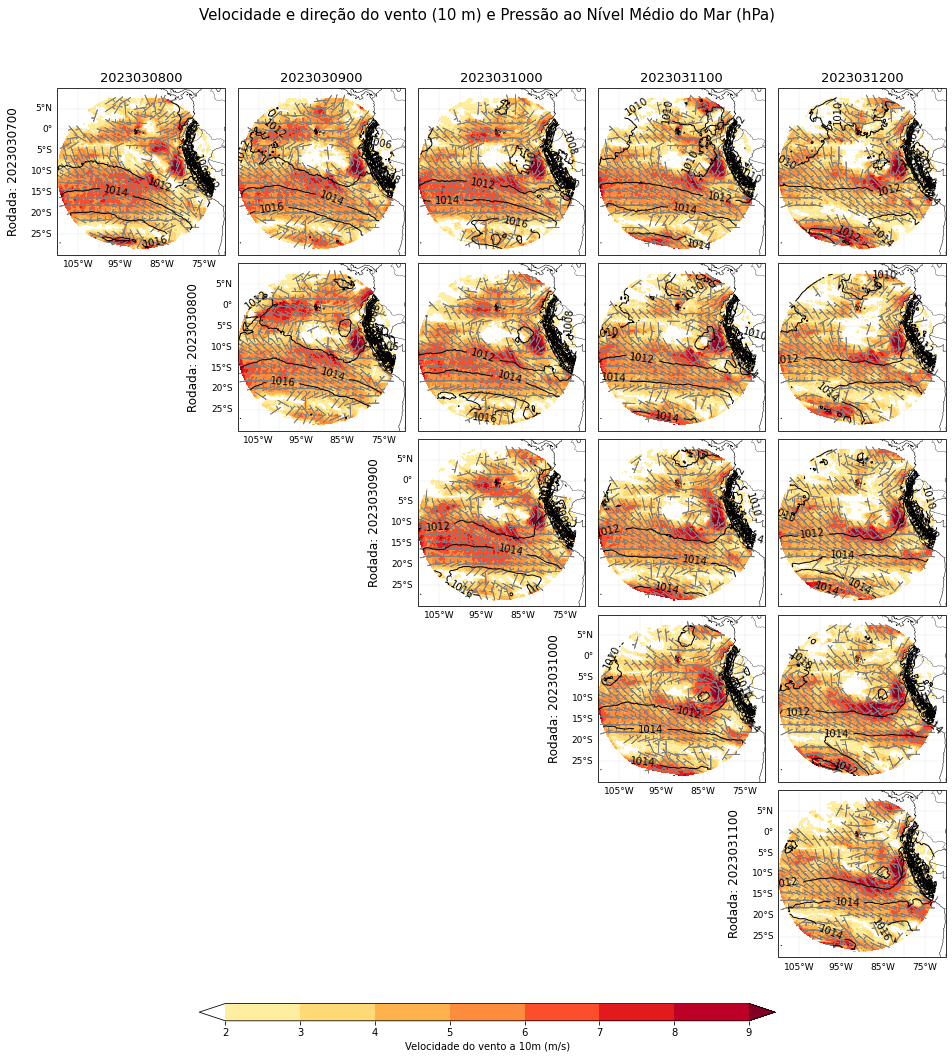

✅ Figura salva como previsao_pressao_vento.png


In [14]:
# --- FIGURA ---
# Cria uma grade de painéis (subgráficos) para mostrar mapas de várias rodadas e previsões.
fig, axs = plt.subplots(
    len(rodadas), len(previsoes),  # Linhas = número de rodadas, colunas = número de previsões.
    figsize=(16, 16),  # Tamanho da figura em polegadas (grande para caber todos os painéis).
    subplot_kw=dict(projection=ccrs.PlateCarree()),  # Usa projeção de mapa simples.
    gridspec_kw={'hspace':0.05, 'wspace':0.05}  # Espaçamento pequeno entre painéis.
)
# --- LOOP DE PLOTAGEM ---
# Para cada combinação de rodada e previsão, cria um mapa no painel correspondente.
for i, rodada in enumerate(rodadas):
    for j, previsao in enumerate(previsoes):
        ax = axs[i,j]  # Seleciona o painel atual.
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Define os limites do mapa.

        # Adiciona rótulo com a data da rodada na primeira coluna visível.
        if j == primeira_coluna_com_dado[i]:
            ax.set_visible(True)
            ax.text(-0.3, 0.5, f"Rodada: {rodada}", fontsize=12, va='center', rotation=90, transform=ax.transAxes)

#         try:
        if rodada == previsao:  # Se datas iguais, painel fica vazio.
            ax.set_visible(False)
            continue

        # Verifica se arquivos do modelo existem.
        if not data_io.check_monan(rodada,previsao):
            print("⚠️ Arquivos do modelo ausentes -> painel vazio")
            ax.set_visible(False)
            continue
        else:
            print("Plotando para este painel")


        # Abre e lê dados do modelo.
        ds_atual = data_io.load_monan(rodada,previsao)

        # Extrai coordenadas (tratando 1D ou 2D).
        lons = ds_atual['longitude'][:]
        lats = ds_atual['latitude'][:] 

        pres = ds_atual.variables['mslp'][0, :, :].astype(float)/100.0  # Pressão ao nível do mar (em hPa).
        u10 = ds_atual.variables['u10'][0, :, :].astype(float) # Componente leste-oeste do vento a 10m.
        v10 = ds_ant.variables['v10'][0, :, :].astype(float) # Componente norte-sul do vento a 10m.
        ws = np.sqrt(u10**2 + v10**2)  # Calcula a velocidade do vento (magnitude).


        # --- PLOT ---
        # Adiciona elementos geográficos ao mapa: linhas de costa, fronteiras, estados.
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.add_feature(cfeature.STATES, linewidth=0.2)

        # Define intervalos para a velocidade do vento (em m/s).
        data_min = 2
        data_max = 10 
        interval = 1
        levels = np.arange(data_min, data_max, interval)

        # Define paleta de cores para o mapa de vento.
        cmap=color_setup.cores_wind()

        # Plota o mapa preenchido com a velocidade do vento.
        img1 = ax.contourf(lons, lats, ws, cmap=cmap, levels=levels, extend='both')    

        # --- PRESSÃO ---
        # Plota linhas de contorno para pressão (isóbaras).
        levels_pres = np.arange(500, 1050, 2)
        img_pres = ax.contour(lons, lats, pres, colors='black', linewidths=1, levels=levels_pres, transform=ccrs.PlateCarree())
        ax.clabel(img_pres, inline=1, fontsize=10, fmt='%1.0f', colors='black')  # Adiciona valores nas linhas.

        # --- VENTO (BARBELAS) ---
        # Adiciona setas (barbelas) para mostrar direção e força do vento.
        flip = np.zeros((u10.shape[0], u10.shape[1]))
        flip[lats < 0] = 1  # Inverte setas no hemisfério sul para correta orientação.
        img_barbs = ax.barbs(
            lons[::20], lats[::20],  # Espaçamento para evitar excesso de setas.
            u10[::20, ::20], v10[::20, ::20],
            length=5.0,
            sizes=dict(emptybarb=0.0, spacing=0.2, height=0.5),
            linewidth=0.8,
            pivot='middle',
            barbcolor='gray',
            flip_barb=flip[::20, ::20],
            transform=ccrs.PlateCarree()
        )

        # --- GRIDLINES ---
        # Adiciona linhas de grade com rótulos de latitude e longitude.
        gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='dimgray', alpha=0.4)
        gl.top_labels = False  # Sem rótulos no topo.
        gl.right_labels = False  # Sem rótulos à direita.
        gl.xlabel_style = {'size':9}  # Tamanho da fonte dos rótulos.
        gl.ylabel_style = {'size':9}

        # Rótulos de latitude só na primeira coluna com dados.
        if j == primeira_coluna_com_dado[i]:
            gl.left_labels = True
        else:
            gl.left_labels = False

        # Rótulos de longitude só na última linha com dados.
        if i != ultima_linha_com_dado[j]:
            gl.bottom_labels = False

        # Adiciona título com a data da previsão na primeira linha.
        if i==0:
            ax.set_title(previsao, fontsize=13)

        ds_atual.close()  # Fecha o arquivo para liberar memória.

#         except Exception as e:  # Se houver erro (ex.: arquivo corrompido), esconde painel.
#             print(f"❌ Erro rodada {rodada}, previsão {previsao}: {e}")
#             ax.set_visible(False)
#             continue

# --- COLORBAR E SALVAMENTO ---
# Adiciona uma barra de cores na parte inferior para explicar a escala de velocidade do vento.
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.015])
cbar = fig.colorbar(img1, cax=cbar_ax, orientation='horizontal', ticks=levels,
                    label='Velocidade do vento a 10m (m/s)')

# Título geral da figura.
plt.suptitle("Velocidade e direção do vento (10 m) e Pressão ao Nível Médio do Mar (hPa)", fontsize=15, y=0.95)
plt.savefig("previsao_pressao_vento.png", dpi=300, bbox_inches='tight')  # Salva a imagem.
plt.show()
plt.close()  # Fecha a figura para liberar memória.
print("✅ Figura salva como previsao_pressao_vento.png")

# 4 Água precipitável, vento em 850 hPa e Omega em 500 hPa

## Geração da figura

Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030800.00.00.x1.5898242L55.nc
<xarray.Variable (latitude: 543, longitude: 543)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Attributes:
    units:      m s^{-1}
    long_name:  Reconstructed zonal wind at cell centers, interpolated to iso...
Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030900.00.00.x1.5898242L55.nc
<xarray.Variable (latitude: 543, longitude: 543)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan

<xarray.Variable (latitude: 543, longitude: 543)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Attributes:
    units:      m s^{-1}
    long_name:  Reconstructed zonal wind at cell centers, interpolated to iso...
Plotando para este painel
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023031000/MONAN_DIAG_R_POS_GFS_2023031000_2023031200.00.00.x1.5898242L55.nc
<xarray.Variable (latitude: 543, longitude: 543)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Att

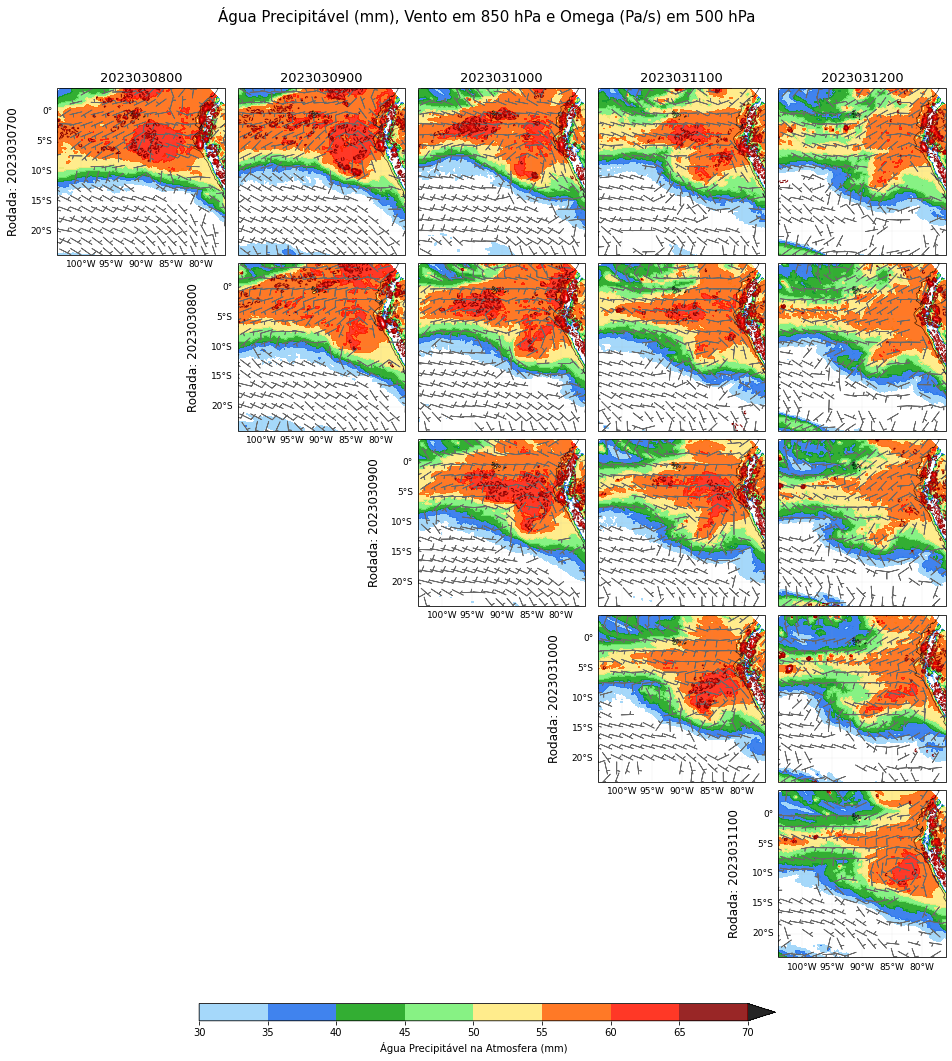

✅ Figura salva como previsao_ap_omega_vento.png


In [61]:
# --- FIGURA ---
# Cria grade de painéis para os mapas.
fig, axs = plt.subplots(
    len(rodadas), len(previsoes),
    figsize=(16, 16),
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw={'hspace':0.05, 'wspace':0.05}
)
# --- LOOP DE PLOTAGEM ---
# Para cada combinação de rodada e previsão, cria um mapa no painel correspondente.
for i, rodada in enumerate(rodadas):
    for j, previsao in enumerate(previsoes):
        ax = axs[i,j]  # Seleciona o painel atual.
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Define os limites do mapa.

        # Adiciona rótulo com a data da rodada na primeira coluna visível.
        if j == primeira_coluna_com_dado[i]:
            ax.set_visible(True)
            ax.text(-0.3, 0.5, f"Rodada: {rodada}", fontsize=12, va='center', rotation=90, transform=ax.transAxes)

        try:
            if rodada == previsao:  # Se datas iguais, painel fica vazio.
                ax.set_visible(False)
                continue

            # Verifica se arquivos do modelo existem.
            if not data_io.check_monan(rodada,previsao):
                print("⚠️ Arquivos do modelo ausentes -> painel vazio")
                ax.set_visible(False)
                continue
            else:
                print("Plotando para este painel")


            # Abre e lê dados do modelo.
            ds_atual = data_io.load_monan(rodada,previsao)

            # Extrai coordenadas (tratando 1D ou 2D).
            lons = ds_atual['longitude'][:]
            lats = ds_atual['latitude'][:]

            ap = ds_atual.variables['precipw'][0, :, :].astype(float)  # Quantidade de água na atmosfera (mm)
            u850 = ds_atual.variables['uzonal'][0, 2, :, :].astype(float) # Vento leste-oeste a 850 hPa.
            v850 = ds_atual.variables['umeridional'][0, 2, :, :].astype(float) # Vento norte-sul a 850 hPa.
            omega = ds_atual.variables['omega'][0, 5, :, :].astype(float)   # Movimento vertical do ar a 500 hPa (Pa/s).

                    # --- PLOT ---
            # Adiciona elementos geográficos.
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            ax.add_feature(cfeature.STATES, linewidth=0.2)

            # Define intervalos para água precipitável.
            data_min = 30
            data_max = 75 
            interval = 5
            levels_ap = np.arange(data_min, data_max, interval)

            # Define paleta de cores para o mapa de vento.
            cmap=color_setup.cores_pw()


            # Plota contorno preenchido de água precipitável.
            img1 = ax.contourf(lons, lats, ap, cmap=cmap, levels=levels_ap, extend='max', alpha=0.85)

            # Ticks para a colorbar.
            ticks = [30, 35, 40, 45, 50, 55, 60, 65, 70]

            # Barbelas de vento a 850 hPa.
            flip = np.zeros((u850.shape[0], u850.shape[1]))
            flip[lats < 0] = 1
            img_barbs = ax.barbs(
                lons[::20], lats[::20],
                u850[::20, ::20], v850[::20, ::20],
                length=5.0,
                sizes=dict(emptybarb=0.0, spacing=0.2, height=0.5),
                linewidth=0.8,
                pivot='middle',
                barbcolor='dimgray',
                flip_barb=flip[::20, ::20],
                transform=ccrs.PlateCarree()
            )

            # Intervalos para omega (movimento vertical).
            data_min = -5
            data_max = -0.1 
            interval = 0.2
            levels = np.arange(data_min, data_max, interval)

            # Plota contorno de omega (suavizado).
            img5 = ax.contour(lons, lats, gaussian_filter(omega, 2), cmap='seismic', linestyles='dashed', linewidths=1.0, levels=levels, zorder=2)

            # --- GRIDLINES ---
            gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='darkgray', alpha=0.4)
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {'size':9}
            gl.ylabel_style = {'size':9}

            if j == primeira_coluna_com_dado[i]:
                gl.left_labels = True
            else:
                gl.left_labels = False

            if i != ultima_linha_com_dado[j]:
                gl.bottom_labels = False

            if i==0:
                ax.set_title(previsao, fontsize=13)

            ds_atual.close()

        except Exception as e:
            print(f"❌ Erro rodada {rodada}, previsão {previsao}: {e}")
            ax.set_visible(False)
            continue

# --- COLORBAR E SALVAMENTO ---
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.015])
cbar = fig.colorbar(img1, cax=cbar_ax, orientation='horizontal', ticks=ticks,
                    label='Água Precipitável na Atmosfera (mm)')

plt.suptitle("Água Precipitável (mm), Vento em 850 hPa e Omega (Pa/s) em 500 hPa", fontsize=15, y=0.95)
plt.savefig("previsao_ap_omega_vento.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✅ Figura salva como previsao_ap_omega_vento.png")

        

# 5 Avalia vorticidade

### Limites geográficos do mapa (ajustados para a área de interesse)

In [42]:
lon_min, lon_max = -104, -76
lat_min, lat_max = -24, 4

### DADOS DE OBSERVAÇÃO 

In [43]:
# time, lon_obs, lat_obs
OBS_DATA = {
    "2023030700": {"lon": -87.6995, "lat": -7.7700},
    "2023030800": {"lon": -85.7371, "lat": -6.5211},
    "2023030900": {"lon": -85.5587, "lat": -6.4319},
    "2023031000": {"lon": -85.7371, "lat": -7.2348},
    "2023031100": {"lon": -84.0423, "lat": -8.9296},
    "2023031200": {"lon": -84.1315, "lat": -10.5352}
}

###  PARÂMETROS DE VISUALIZAÇÃO

In [54]:
# Nível de pressão 850 hPa (Índice vertical para o seu dataset)
NIVEL_PRESSAO = 2 

# Suavização da Vorticidade (sigma em pontos de grade)
SMOOTH_SIGMA = 3.0

# Contornos de Pressão (MSLP)
pressao_levels = np.arange(990, 1024, 2) # Isolinas de 2 em 2 hPa

# Escala de Vorticidade (s^-1)
vort_min = -10e-5 # Valor mínimo (azul escuro)
vort_max = 10e-5  # Valor máximo (vermelho escuro)
vort_interval = 1e-5
vort_levels = np.arange(vort_min, vort_max + vort_interval, vort_interval)


#### FIGURA

Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030800.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030900.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023031000.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023031100.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023031200.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//202

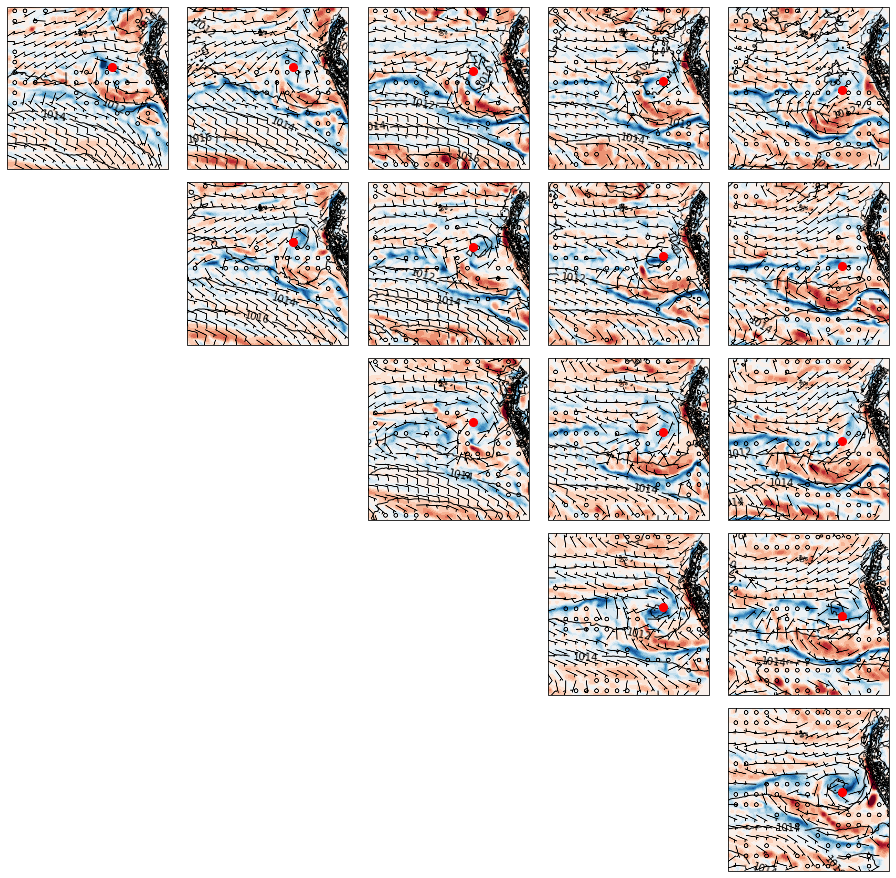

In [66]:
# Cria uma grade de painéis (subgráficos)
n_linhas, n_colunas = len(rodadas), len(previsoes)
fig, axs = plt.subplots(
    n_linhas, n_colunas,
    figsize=(16,16),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)

# Ajusta o espaçamento para as barbelas e títulos
fig.subplots_adjust(hspace=0.08, wspace=0.05, top=0.9, bottom=0.15)

# --- DETECÇÃO DE DADOS VÁLIDOS ---
# Arrays para ajudar a definir quais painéis precisam de rótulos de latitude/longitude
tem_dado = np.zeros((n_linhas, n_colunas), dtype=bool)

# Loop principal
for i, rodada in enumerate(rodadas):
    rodada_dt = datetime.strptime(rodada, "%Y%m%d%H")
    
    for j, previsao in enumerate(previsoes):
        previsao_dt = datetime.strptime(previsao, "%Y%m%d%H")
        
        # Garante que 'ax' seja um objeto de eixo único
        if n_linhas == 1 and n_colunas == 1:
            ax = axs
        elif n_linhas == 1:
            ax = axs[j]
        elif n_colunas == 1:
            ax = axs[i]
        else:
            ax = axs[i, j]
        
        ax.set_extent([lon_min, lon_max, lat_min, lat_max])

        # Lógica para omitir painel da análise (rodada == previsao) 
        if rodada == previsao:
            ax.set_visible(False)
            continue
        
        # Pula a iteração se a data da previsão for anterior à rodada
        if previsao_dt < rodada_dt:
            ax.set_visible(False)
            continue
        
#         try:
        # Abre e lê dados do modelo.
        ds_atual = data_io.load_monan(rodada,previsao)

        # Extrai coordenadas (tratando 1D ou 2D).
        lons = ds_atual['longitude'][:]
        lats = ds_atual['latitude'][:] 

        # Pressão ao Nível Médio do Mar (MSLP)
        mslp = ds_atual.variables['mslp'][0, :, :].astype(float)            
        if np.nanmean(mslp) > 2000: mslp /= 100.0 # Conversão de Pa para hPa

        u850 = np.asarray(ds_atual.variables['uzonal'][0, NIVEL_PRESSAO, :, :].astype(float))
        v850 = np.asarray(ds_atual.variables['umeridional'][0, NIVEL_PRESSAO, :, :].astype(float))

        # 2. CÁLCULO DA VORTICIDADE EM 850 hPa

        u_q = units.Quantity(u850, "m/s")
        v_q = units.Quantity(v850, "m/s")

        dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
        vort_q = mpcalc.vorticity(u_q, v_q, dx=dx, dy=dy)
        vort = vort_q.to('1/s').magnitude

        # Suaviza a vorticidade (Usando SciPy para robustez)
        vort_temp = np.nan_to_num(vort, nan=0.0) 
        vort_smoothed = gaussian_filter(vort_temp, sigma=SMOOTH_SIGMA, mode='nearest', truncate=3.0)

        # 3. PLOTAGEM DOS CAMPOS

        # A) Vorticidade em Cores (Contorno Preenchido)
        img1 = ax.contourf(lons, lats, vort_smoothed, 
                           levels=vort_levels, 
                           cmap='RdBu_r', 
                           extend='both', 
                           transform=ccrs.PlateCarree())

        # B) Pressão ao Nível Médio do Mar (MSLP) em Isolinhas
        img2 = ax.contour(lons, lats, mslp, 
                          levels=pressao_levels, 
                          colors='black', 
                          linewidths=1, 
                          transform=ccrs.PlateCarree(),
                          zorder=3) 

        ax.clabel(img2, inline=1, fontsize=10, fmt='%d', colors='k')

        # C) Vento em 850 hPa em Barbelas (Quiver)
        skip = 20 # Subamostragem
        ax.barbs(lons[::skip], lats[::skip], u850[::skip, ::skip], v850[::skip, ::skip], 
                 length=5, color='k', linewidth=0.5, zorder=4)

        # D) Ponto de Observação (adicionado)
        if previsao in OBS_DATA:
            lon_obs = OBS_DATA[previsao]["lon"]
            lat_obs = OBS_DATA[previsao]["lat"]

            # Plota o ponto de observação na data de previsão
            ax.plot(lon_obs, lat_obs, 
                    marker='o',         # Marcador de círculo
                    color='red',        # Cor vermelha
                    markersize=8,       # Tamanho maior para destaque
                    transform=ccrs.PlateCarree(), # TRANSFORMAÇÃO CRUCIAL
                    zorder=5,           # Garante que o ponto esteja no topo
                    label=f"Obs {previsao}")

        # 4. ELEMENTOS DO MAPA E TÍTULOS
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.add_feature(cfeature.STATES, linewidth=0.3)
        tem_dado[i, j] = True

        ds_atual.close()

#         except Exception as e:
#             # O painel é desativado em caso de erro (ex: arquivo corrompido ou outro problema)
#             print(f"❌ Erro rodada {rodada}, previsão {previsao}: {e}")
#             ax.set_visible(False)
#             continue


# 6 Avalia trajetória prevista

### Limites geográficos (Longitudes e Latitudes) da "caixa" onde o ciclone é procurado.

In [16]:
lon_min, lon_max = -95, -80 # Longitude (Oeste a Leste)
lat_min, lat_max = -20, 5 # Latitude (Sul a Norte)

### Datas das rodadas (início das simulações) (Inclui o dia 12)

In [27]:
rodadas = ["2023030700", "2023030800", "2023030900", "2023031000", "2023031100"]

### Raios de busca local (em km) que serão usados no rastreamento para refinar a posição do centro.

In [28]:
radii_km = [100, 250, 500, 800, 1500]

### Cria o diretório de saída para salvar os resultados, se ele não existir

In [29]:
out_dir = "tracks_csv"
os.makedirs(out_dir, exist_ok=True)

## 1) Extrai centros das análises (usadas como "observadas")

In [30]:
# Dicionário para armazenar a posição central (lon, lat, pressão) das análises.
# As análises (lead time 0h) são usadas como "trajetória observada" de referência.
obs_centers = {}

In [31]:
print("Extraindo centros das análises (usadas como observadas)...")

Extraindo centros das análises (usadas como observadas)...


In [32]:
for rodada in rodadas:

    if not data_io.check_monan(rodada,rodada):
        print(f"⚠️  Análise ausente para data: {rodada}")
        continue
    try:

        # Abre e lê dados do modelo.
        ds_atual = data_io.load_monan(rodada,rodada)

        # Extrai coordenadas (tratando 1D ou 2D).
        lons = ds_atual['longitude'][:]
        lats = ds_atual['latitude'][:]

        lons = aux.lon_to_minus180_180(lons)

        mslp = ds_atual.variables["mslp"][:]

        # Ajusta a dimensão da pressão se necessário (remove a dimensão de tempo se presente)
        if mslp.ndim == 3:
            mslp = mslp[0, :, :]
        # Converte de Pascal (Pa) para HectoPascal (hPa) se os valores forem muito altos
        if np.nanmean(mslp) > 2000:
            mslp /= 100.0

        lons2d, lats2d = aux.ensure_2d_lonlat(lons, lats)
        # Cria uma máscara para selecionar apenas os dados dentro da região de busca configurada
        mask = (lons2d >= lon_min) & (lons2d <= lon_max) & (lats2d >= lat_min) & (lats2d <= lat_max)

        # Aplica a máscara: fora da região de busca, o valor é NaN (Not a Number)
        mslp_masked = np.where(mask, mslp, np.nan)

        # Encontra o índice do menor valor (mínimo de MSLP = centro do ciclone)
        if np.all(np.isnan(mslp_masked)):
            # Se toda a área mascarada for NaN (ciclone fora da caixa), usa o mínimo global
            idx = np.nanargmin(mslp)
        else:
            # Caso contrário, usa o mínimo dentro da caixa de busca
            idx = np.nanargmin(mslp_masked)

        # Converte o índice 1D (flat) para coordenadas 2D (linha/coluna)
        iy, ix = np.unravel_index(idx, mslp.shape)

        # Armazena a posição (lon/lat) e a pressão central (p_c)
        lon_c, lat_c, p_c = float(lons2d[iy, ix]), float(lats2d[iy, ix]), float(mslp[iy, ix])
        obs_centers[rodada] = (lon_c, lat_c, p_c)
        print(f"  {rodada}: lon={lon_c:.2f}, lat={lat_c:.2f}, mslp={p_c:.2f}")
        ds_atual.close()
    except Exception as e:
        print(f"❌ Erro lendo análise {analise_path}: {e}")
        continue


Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030700.00.00.x1.5898242L55.nc
  2023030700: lon=-87.70, lat=-7.77, mslp=1008.19
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030800/MONAN_DIAG_R_POS_GFS_2023030800_2023030800.00.00.x1.5898242L55.nc
  2023030800: lon=-85.74, lat=-6.52, mslp=1008.75
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030900/MONAN_DIAG_R_POS_GFS_2023030900_2023030900.00.00.x1.5898242L55.nc
  2023030900: lon=-85.56, lat=-6.43, mslp=1009.57
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023031000/MONAN_DIAG_R_POS_GFS_2023031000_2023031000.00.00.x1.5898242L55.nc
  2023031000: lon=-85.74, lat=-7.23, mslp=1009.00
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_caso

### Salva os centros das análises em um arquivo CSV para referência

In [33]:
obs_csv = os.path.join(out_dir, "track_obs_all.csv")
with open(obs_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["time", "lon_obs", "lat_obs", "mslp_hPa_obs"])
    for k in sorted(obs_centers.keys()):
        lon_o, lat_o, p_o = obs_centers[k]
        w.writerow([k, f"{lon_o:.4f}", f"{lat_o:.4f}", f"{p_o:.2f}"])
print(f"✅ Centros observados salvos em: {obs_csv}")

✅ Centros observados salvos em: tracks_csv/track_obs_all.csv


In [34]:
# Lista para acumular todos os resultados de erro de todas as rodadas
summary_rows = []

for rodada in rodadas:
    print("\n===================================")
    print(f"Rodada {rodada}")
    rodada_dt = datetime.strptime(rodada, "%Y%m%d%H")
    csvname = os.path.join(out_dir, f"track_{rodada}.csv")

    # Variáveis para rastrear a última posição encontrada (usadas para a busca local)
    prev_lon, prev_lat = None, None
    found_first = False # Flag para saber se o primeiro ponto da track foi encontrado

    with open(csvname, "w", newline="") as fcsv:
        w = csv.writer(fcsv)
        # Cabeçalho do arquivo CSV da trajetória
        w.writerow(["init", "lead_h", "forecast_time",
                    "lon_fc", "lat_fc", "mslp_fc",
                    "lon_obs", "lat_obs", "mslp_obs", "erro_km"])

        # Loop sobre os tempos de previsão (lead times)
        for fh in forecast_steps_h:
            fc_dt = rodada_dt + timedelta(hours=fh) # Calcula o tempo de previsão real
            fc_str = fc_dt.strftime("%Y%m%d%H")    
            
            if not data_io.check_monan(rodada,fc_str):
                print(f"⚠️  Análise ausente para data: {rodada} {fc_str}")
                continue
#             try:            

            # Abre e lê dados do modelo.
            ds_atual = data_io.load_monan(rodada,fc_str)

            # Extrai coordenadas (tratando 1D ou 2D).
            lons = ds_atual['longitude'][:]
            lats = ds_atual['latitude'][:]

            lons = aux.lon_to_minus180_180(lons)

            mslp = ds_atual.variables["mslp"][:]
            ds_atual.close()

            # Ajusta a dimensão da pressão se necessário (remove a dimensão de tempo se presente)
            if mslp.ndim == 3:
                mslp = mslp[0, :, :]
            # Converte de Pascal (Pa) para HectoPascal (hPa) se os valores forem muito altos
            if np.nanmean(mslp) > 2000:
                mslp /= 100.0
                
            mslp = np.asarray(mslp)

            lons2d, lats2d = aux.ensure_2d_lonlat(lons, lats)
            # "Achata" os arrays para facilitar a busca de índice
            lons_flat, lats_flat, mslp_flat = lons2d.ravel(), lats2d.ravel(), mslp.ravel()

            if not found_first:
                # Rastreamento: Passo 1 (Busca do primeiro ponto da track)

                # Máscara do domínio global (para a busca inicial)
                mask = (lons2d >= lon_min) & (lons2d <= lon_max) & (lats2d >= lat_min) & (lats2d <= lat_max)
                mask_flat = mask.ravel()

                if np.any(mask_flat):
                    # Se houver pontos válidos, busca o mínimo de MSLP dentro da caixa
                    vals = np.where(mask_flat, mslp_flat, np.nan)
                    idx = np.nanargmin(vals)
                else:
                    # Se não houver, busca o mínimo em todo o domínio (fallback)
                    idx = np.nanargmin(mslp_flat)

                # Armazena a primeira posição e inicializa a posição anterior
                lon_c, lat_c, p_c = float(lons_flat[idx]), float(lats_flat[idx]), float(mslp_flat[idx])
                found_first, prev_lon, prev_lat = True, lon_c, lat_c
            else:
                # Rastreamento: Passo 2 (Busca local)

                # Calcula a distância de cada ponto da grade em relação à posição anterior
                dists = aux.haversine_km(prev_lon, prev_lat, lons_flat, lats_flat)
                found = False

                # Tenta encontrar o mínimo dentro de raios circulares sucessivamente maiores
                for rkm in radii_km:
                    # Máscara circular (pontos dentro do raio atual)
                    mask_r = (dists <= rkm)

                    if np.any(mask_r):
                        # Pega os valores de MSLP apenas dentro do raio atual
                        vals = np.where(mask_r, mslp_flat, np.nan)
                        idx = np.nanargmin(vals)

                        # Atualiza a posição encontrada e a posição anterior para o próximo passo
                        lon_c, lat_c, p_c = float(lons_flat[idx]), float(lats_flat[idx]), float(mslp_flat[idx])
                        prev_lon, prev_lat = lon_c, lat_c
                        found = True
                        break # Ponto encontrado, sai do loop de raios

                if not found:
                    # Se a busca local em todos os raios falhar (o que é raro para MSLP),
                    # volta a buscar o mínimo em todo o domínio global (fallback)
                    idx = np.nanargmin(mslp_flat)
                    lon_c, lat_c, p_c = float(lons_flat[idx]), float(lats_flat[idx]), float(mslp_flat[idx])
                    prev_lon, prev_lat = lon_c, lat_c

            # --- Cálculo de Erro e Saída ---

            # Pega a posição "observada" (análise) correspondente ao tempo de previsão (fc_str)
            # O fatiamento "fc_str[:10]" garante que apenas a data/hora da análise seja usada (ex: 2023030700)
            lon_obs, lat_obs, p_obs = obs_centers.get(fc_str[:10], (np.nan, np.nan, np.nan))
            erro_km = np.nan

            # Calcula o erro de posição (distância Haversine) se o ponto observado for válido
            if not np.isnan(lon_obs) and not np.isnan(lat_obs):
                erro_km = aux.haversine_km(lon_c, lat_c, lon_obs, lat_obs)

            # Escreve a linha de resultados no arquivo CSV da rodada
            w.writerow([rodada, fh, fc_str,
                        f"{lon_c:.4f}", f"{lat_c:.4f}", f"{p_c:.2f}",
                        f"{lon_obs:.4f}" if not np.isnan(lon_obs) else "",
                        f"{lat_obs:.4f}" if not np.isnan(lat_obs) else "",
                        f"{p_obs:.2f}" if not np.isnan(p_obs) else "",
                        f"{erro_km:.2f}" if not np.isnan(erro_km) else ""])

            # Armazena os dados para o resumo e plot final
            summary_rows.append([rodada, fh, fc_str, lon_c, lat_c, p_c, lon_obs, lat_obs, p_obs, erro_km])

#             except Exception as e:
#                 print(f"Erro para: {rodada} {fc_str}: {e}")
#                 continue
    print(f"✅ Track salvo: {csvname}")


Rodada 2023030700
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030700.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030800.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023030900.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023031000.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/Galapagos_YAKU//2023030700/MONAN_DIAG_R_POS_GFS_2023030700_2023031100.00.00.x1.5898242L55.nc
Opening  /pesq/share/bam/dist/paulo.kubota/externo/Curso_da_OMM_2025_estudos_de_casos/

## 2) Loop das rodadas: detectar centros previstos e calcular erro

## 3) Salva resumo e plota

In [35]:
# Salva o resumo consolidado de todas as rodadas
summary_csv = "track_error_summary.csv"
with open(summary_csv, "w", newline="") as f:
    w = csv.writer(f)
    # Cabeçalho do arquivo de resumo
    w.writerow(["init", "lead_h", "forecast_time",
                "lon_fc", "lat_fc", "mslp_fc",
                "lon_obs", "lat_obs", "mslp_obs", "erro_km"])
    for row in summary_rows:
        w.writerow(row)
print(f"✅ Resumo salvo: {summary_csv}")

✅ Resumo salvo: track_error_summary.csv


## PLOT 1: TRAJETÓRIAS

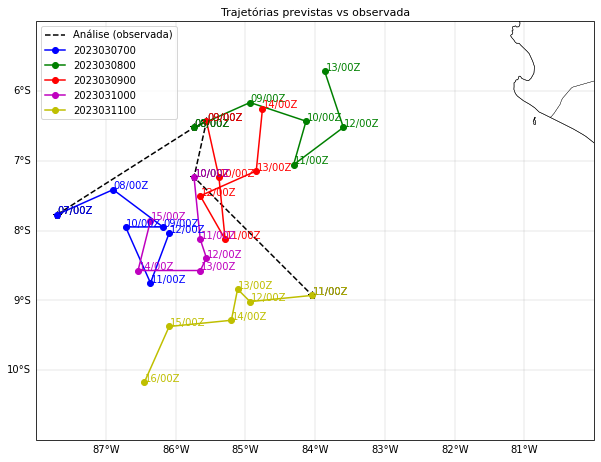

✅ Figura salva: tracks_vs_obs.png


In [36]:
# Cria a figura e o eixo do mapa com a projeção Plate Carree (Lat/Lon simples)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
# Define os limites do mapa (atenção: estes limites são menores que os de busca)
ax.set_extent([-88, -80, -11, -5])
# Adiciona elementos geográficos (necessário o cartopy)
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.STATES, linewidth=0.3)
# Adiciona linhas de grade e etiquetas
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.6)
gl.top_labels, gl.right_labels = False, False

# Desenha a trajetória "observada" (análises)
if obs_centers:
    # Plota os marcadores das análises (estrelas pretas) e o rótulo da data
    for key, (lon_o, lat_o, _) in obs_centers.items():
        ax.plot(lon_o, lat_o, 'k*', markersize=8)
        ax.text(lon_o + 0.01, lat_o + 0.01, f"{key[6:8]}/{key[8:10]}Z", fontsize=10, color='k')
    # Plota a linha tracejada das análises
    obs_lons = [v[0] for v in obs_centers.values()]
    obs_lats = [v[1] for v in obs_centers.values()]
    ax.plot(obs_lons, obs_lats, 'k--', label='Análise (observada)')

# Cores para diferenciar cada rodada de previsão
colors = ['b', 'g', 'r', 'm', 'y', 'c']

# Loop para desenhar cada trajetória prevista
for i, rodada in enumerate(rodadas):
    csvfile = os.path.join(out_dir, f"track_{rodada}.csv")
    if not os.path.exists(csvfile):
        continue
    # Carrega os dados da trajetória
    data = np.genfromtxt(csvfile, delimiter=',', names=True, dtype=None, encoding=None)
    if data.size == 0:
        continue
    lons, lats, times = data['lon_fc'], data['lat_fc'], data['forecast_time']
    # Plota a linha e os marcadores da previsão
    ax.plot(lons, lats, '-o', color=colors[i % len(colors)], label=f"{rodada}")
    # Adiciona as etiquetas de tempo de previsão (data/hora)
    for lonv, latv, tstr in zip(lons, lats, times):
        if np.isnan(lonv) or np.isnan(latv):
            continue
        tstr = str(tstr)
        label = f"{tstr[6:8]}/{tstr[8:10]}Z" if len(tstr) >= 10 else f"{tstr}Z"
        ax.text(lonv + 0.01, latv + 0.01, label, fontsize=10, color=colors[i % len(colors)])

ax.legend(fontsize=10, loc='upper left')
ax.set_title("Trajetórias previstas vs observada", fontsize=11)
plt.savefig("tracks_vs_obs.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✅ Figura salva: tracks_vs_obs.png")

## PLOT 2: ERRO DE POSIÇÃO POR RODADA + MÉDIA

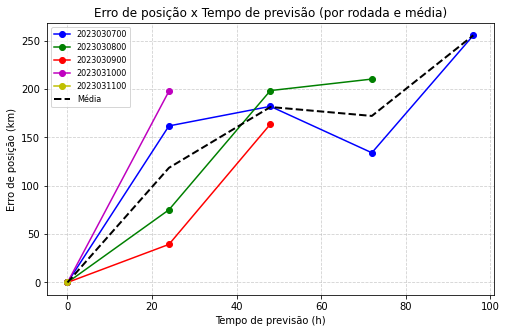

✅ Figura salva: erro_posicao_vs_lead.png
Processamento finalizado com sucesso.


In [40]:
# Carrega os dados do arquivo de resumo (incluindo o erro em km)
summary = np.genfromtxt(summary_csv, delimiter=',', names=True, dtype=None, encoding=None)

plt.figure(figsize=(8, 5))

colors = ['b', 'g', 'r', 'm', 'y', 'c']
erro_agregado = {} # Dicionário para somar os erros por lead time para o cálculo da média

for i, rodada in enumerate(rodadas):
    # Seleciona os dados apenas para a rodada atual
    mask = np.array([str(x) == rodada for x in summary['init']])
    if np.sum(mask) == 0:
        continue

    leads = summary['lead_h'][mask]
    erros = summary['erro_km'][mask]

    # Converte a string de erro para float (lidando com strings vazias como NaN)
    erros = np.array([float(e) if e != '' else np.nan for e in erros])
    # Filtra os dados de erro que são válidos (não NaN)
    leads_valid, erros_valid = leads[~np.isnan(erros)], erros[~np.isnan(erros)]
    if len(leads_valid) == 0:
        continue

    # Plota o erro de posição para a rodada atual
    plt.plot(leads_valid, erros_valid, '-o', color=colors[i % len(colors)], label=rodada)

    # Acumula os erros para o cálculo da média por lead time
    for l, e in zip(leads_valid, erros_valid):
        if l not in erro_agregado:
            erro_agregado[l] = []
        erro_agregado[l].append(e)

# Média agregada: calcula a média dos erros para cada lead time
lead_vals = sorted(erro_agregado.keys())
erro_medio = [np.nanmean(erro_agregado[l]) for l in lead_vals]
# Plota a linha da média (tracejada preta)
plt.plot(lead_vals, erro_medio, 'k--', linewidth=2, label='Média')

# Configurações finais do gráfico de erro
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Tempo de previsão (h)")
plt.ylabel("Erro de posição (km)")
plt.title("Erro de posição x Tempo de previsão (por rodada e média)")
plt.legend(fontsize=8)
plt.savefig("erro_posicao_vs_lead.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Figura salva: erro_posicao_vs_lead.png")

print("Processamento finalizado com sucesso.")